In [156]:
import sys
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn import utils


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Initilize Spotify

In [2]:
username = 'maguenza'
client_id = '8f5145e2a1574aa784b4e4b2dddeebc9'
client_secret = '2c9e490810e048aa91a4b168cc2521cb'


client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Grab all albums for a specific artist
- in this example, let's use Avicii

In [3]:
artist = 'spotify:artist:1vCWHaC5f2uS3yhpwWbIA6'

results = sp.artist_albums(artist, album_type='album')
albums = results['items']
while results['next']:
    results = sp.next(results)
    albums.extend(results['items'])

album_id = []
for album in albums:
    album_id.append(album['id'])

## For every album, grab songs

In [4]:
offset = 0
songs = []
for item in album_id:
    while True:
        content = sp.album_tracks(item,limit=50, offset=offset)
        songs += content['items']
        if content['next'] is not None:
            offset += 100
        else:
            break

## For all the songs, create a dictionary then transpose into a dataframe
- rename index into names then drop index column

In [5]:
new_dict = {item['name']:item for item in songs}

df_songs = pd.DataFrame(new_dict).T['id'].reset_index()
df_songs['name'] = df_songs['index']
del df_songs['index']

In [6]:
df_songs.head()

,id,name
0,5GayeBzzXIEl6fY0cP42Z1,Addicted To You
1,3XfGM99TOeyPsnDtgTqtkT,Addicted To You - Avicii By Avicii
2,1dHYpFcwP21Y1YCWmhhHrs,All You Need Is Love
3,4su2cUR8aGSqtNhz6EwE1a,Always On The Run
4,2BVVmJQZv4fOPWavI9mkIj,Broken Arrows


## Now for all the song ids, find each song's feature and set to dataframe

In [7]:
song_id = []
for x in df_songs['id'].values:
    song_id.append(x)

In [8]:
index = 0
audio_features = []
while index < len(song_id):
    audio_features += sp.audio_features(song_id[index:index + 50])
    index += 50

features_list = []
for features in audio_features:
    features_list.append([features['energy'], features['liveness'],\
                          features['tempo'], features['speechiness'],\
                          features['acousticness'], features['instrumentalness'],\
                          features['time_signature'], features['danceability'],\
                          features['key'], features['duration_ms'],\
                          features['loudness'], features['valence'],\
                          features['mode'], features['type'],\
                          features['uri'],\
                          features['id']])

df = pd.DataFrame(features_list, columns=['energy', 'liveness',\
                                          'tempo', 'speechiness',\
                                          'acousticness', 'instrumentalness',\
                                          'time_signature', 'danceability',\
                                          'key', 'duration_ms', 'loudness',\
                                          'valence', 'mode', 'type', 'uri','id'])

In [9]:
df.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,uri,id
0,0.778,0.082,128.089,0.045,0.049,0.000,4,0.549,1,148387,-4.071,0.318,0,audio_features,spotify:track:5GayeBzzXIEl6fY0cP42Z1,5GayeBzzXIEl6fY0cP42Z1
1,0.470,0.042,125.993,0.085,0.125,0.013,4,0.887,10,331507,-5.423,0.441,1,audio_features,spotify:track:3XfGM99TOeyPsnDtgTqtkT,3XfGM99TOeyPsnDtgTqtkT
2,0.425,0.044,125.017,0.103,0.035,0.036,4,0.767,6,381120,-4.821,0.464,1,audio_features,spotify:track:1dHYpFcwP21Y1YCWmhhHrs,1dHYpFcwP21Y1YCWmhhHrs
3,0.853,0.096,128.027,0.039,0.016,0.020,4,0.514,3,295387,-4.733,0.261,0,audio_features,spotify:track:4su2cUR8aGSqtNhz6EwE1a,4su2cUR8aGSqtNhz6EwE1a
4,0.674,0.102,115.995,0.046,0.049,0.001,4,0.634,7,232760,-7.145,0.298,1,audio_features,spotify:track:2BVVmJQZv4fOPWavI9mkIj,2BVVmJQZv4fOPWavI9mkIj


## Now mere song names and audio features on id to bring in song name

In [10]:
df_final = df.merge(df_songs, left_on = 'id', right_on = 'id', how = 'inner')

In [11]:
df_final.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,uri,id,name
0,0.778,0.082,128.089,0.045,0.049,0.000,4,0.549,1,148387,-4.071,0.318,0,audio_features,spotify:track:5GayeBzzXIEl6fY0cP42Z1,5GayeBzzXIEl6fY0cP42Z1,Addicted To You
1,0.470,0.042,125.993,0.085,0.125,0.013,4,0.887,10,331507,-5.423,0.441,1,audio_features,spotify:track:3XfGM99TOeyPsnDtgTqtkT,3XfGM99TOeyPsnDtgTqtkT,Addicted To You - Avicii By Avicii
2,0.425,0.044,125.017,0.103,0.035,0.036,4,0.767,6,381120,-4.821,0.464,1,audio_features,spotify:track:1dHYpFcwP21Y1YCWmhhHrs,1dHYpFcwP21Y1YCWmhhHrs,All You Need Is Love
3,0.853,0.096,128.027,0.039,0.016,0.020,4,0.514,3,295387,-4.733,0.261,0,audio_features,spotify:track:4su2cUR8aGSqtNhz6EwE1a,4su2cUR8aGSqtNhz6EwE1a,Always On The Run
4,0.674,0.102,115.995,0.046,0.049,0.001,4,0.634,7,232760,-7.145,0.298,1,audio_features,spotify:track:2BVVmJQZv4fOPWavI9mkIj,2BVVmJQZv4fOPWavI9mkIj,Broken Arrows


## Now, let's find more songs to build the dancing_algorithm

In [57]:
related_artists = sp.artist_related_artists(artist)

In [59]:
ra_ids = []
for k,v in related_artists.items():
    ra_ids.append(v)

In [82]:
array = np.array(ra_ids).reshape(20)
df0 = pd.DataFrame(array, columns = ['name'])
other_id = [d.get('id') for d in df0.name]

In [107]:
other_id

['4AVFqumd2ogHFlRbKIjp1t',
 '4D75GcNG95ebPtNvoNVXhz',
 '5fahUm8t5c0GIdeTq0ZaG8',
 '2XnBwblw31dfGnspMIwgWz',
 '1h6Cn3P4NGzXbaXidqURXs',
 '3TVjdmhfFoYJLgBEkkZTBm',
 '5ChF3i92IPZHduM7jN3dpg',
 '6i1GVNJCyyssRwXmnaeEFH',
 '6lB8vOoI4DRrrVxXwuV19c',
 '2o5jDhtHVPhrJdv3cEQ99Z',
 '4sTQVOfp9vEMCemLw50sbu',
 '2u8P7EawurNYoIzRtr5Knk',
 '68dW5BU6sdVNf099EylxEt',
 '4cSYNpczcvTUpnPMFDLsIc',
 '0XNvr6bnNywV946ZKaJtr0',
 '3tLYpanVDomWAZqF82NPds',
 '4ehtJnVumNf6xzSCDk8aLB',
 '6BrvowZBreEkXzJQMpL174',
 '0daugAjUgbJSqdlyYNwIbT',
 '73jBynjsVtofjRpdpRAJGk']

In [129]:
other_results = []
other_albums = []
for item in other_id:
    results1 = sp.artist_albums(item, album_type='album')
    albums1 = results1['items']
    #other_albums.append(albums1)
    while results1['next']:
        results1 = sp.next(results1)
        other_results.append(results1)
        other_albums.extend(results1['items'])
        

In [135]:
other_album_id = []
for album in other_albums:
    other_album_id.append(album['id'])

In [138]:
offset = 0
other_songs = []
for item in other_album_id:
    while True:
        content1 = sp.album_tracks(item,limit=50, offset=offset)
        other_songs += content1['items']
        if content1['next'] is not None:
            offset += 100
        else:
            break

In [141]:
new_dict1 = {item['name']:item for item in other_songs}

df1_songs = pd.DataFrame(new_dict1).T['id'].reset_index()
df1_songs['name'] = df1_songs['index']
del df1_songs['index']

In [143]:
len(df1_songs)

1053

In [221]:
other_song_id = []
for x in df1_songs['id'].values:
    other_song_id.append(x)
    
index = 0
audio_features1 = []
while index < len(other_song_id):
    audio_features1 += sp.audio_features(other_song_id[index:index + 50])
    index += 50

features_list1 = []
for features in audio_features1:
    features_list1.append([features['tempo'], features['liveness'],\
                          features['energy'], features['speechiness'],\
                          features['acousticness'], features['instrumentalness'],\
                          features['danceability'],\
                          features['loudness'], features['valence'],\
                          features['duration_ms'],features['uri'], features['id']])

df_dance = pd.DataFrame(features_list1, columns=['tempo', 'liveness',\
                                          'energy', 'speechiness',\
                                          'acousticness', 'instrumentalness',\
                                          'danceability',\
                                          'loudness', 'valence',\
                                          'duration_ms', 'uri','id'])

In [222]:
for col in df_dance.iloc[:2,1:-3]:
    df_dance[col] = df_dance[col] * 100

In [223]:
df_dance.dtypes

tempo               float64
liveness            float64
energy              float64
speechiness         float64
acousticness        float64
instrumentalness    float64
danceability        float64
loudness            float64
valence             float64
duration_ms           int64
uri                  object
id                   object
dtype: object

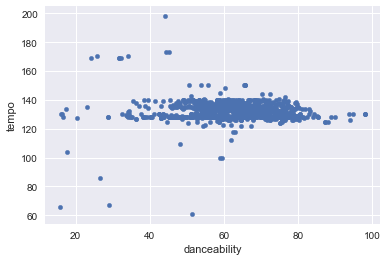

In [247]:
df_dance.plot(kind='scatter', x='danceability', y='tempo')

In [226]:
encoded = df_dance.copy()
encoded = encoded.drop(['uri','id'],axis=1)
for col in encoded:
    encoded[col] = encoded[col].astype(int)

y = encoded['danceability']
X = encoded.drop('danceability', axis=1)

In [227]:
encoded.head()

,tempo,liveness,energy,speechiness,acousticness,instrumentalness,danceability,loudness,valence,duration_ms
0,149,9,82,4,0,77,50,-914,57,478683
1,136,8,83,4,0,89,75,-786,24,310547
2,134,9,65,7,0,89,78,-1137,16,376640
3,134,40,90,5,0,79,62,-678,41,537187
4,134,30,91,5,0,79,62,-679,43,539173


In [228]:
seed = 11
clf = ExtraTreesClassifier(n_jobs=2, random_state=seed)
clf.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [231]:
features = list(zip(X.columns, np.transpose(clf.feature_importances_ * 100)))
features = pd.DataFrame(features, columns=['feature','importance']).sort_values('importance', ascending=False)
features['importance'] = features['importance'].astype(int)
features.head(10)

,feature,importance
8,duration_ms,12
7,valence,12
6,loudness,12
2,energy,11
0,tempo,11
1,liveness,11
5,instrumentalness,11
3,speechiness,10
4,acousticness,5


In [242]:
#test_scenario = pd.DataFrame({'track_id': df_dance.index.tolist()})
test_scenario = df_dance.copy()
test_scenario = df_dance.drop(['danceability','uri','id'], axis = 1)

In [244]:
test_scenario['dance_predicion'] = clf.predict(test_scenario)

In [245]:
test_scenario.head()

,tempo,liveness,energy,speechiness,acousticness,instrumentalness,loudness,valence,duration_ms,dance_predicion
0,149.977,9.930,82.300,4.010,0.299,77.400,-914.700,57.500,478683,50
1,136.016,8.940,83.500,4.630,0.053,89.400,-786.700,24.100,310547,75
2,134.018,9.760,65.700,7.810,0.088,89.800,-1137.000,16.800,376640,78
3,134.011,40.100,90.800,5.190,0.855,79.400,-678.700,41.100,537187,62
4,134.007,30.300,91.200,5.130,0.872,79.800,-679.400,43.400,539173,62


## For testing:
- instance-based modeling
- bayesian